In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm as Norm

from os import listdir
from os.path import join

In [28]:
def imread(path):
    return np.array([cv2.imread(join(path, file), cv2.IMREAD_COLOR) for file in sorted(listdir(path))])

def center_crop(img, ratio=0.1):
    h, w = img.shape[:-1]
    h, w = int(h*ratio), int(w*ratio)
    return img[h:-h, w:-w]

def indices_sampling(images, size=50):
    # return a random-sampling indices (in 1-d representation)
    
    # avoid sampling edge points
    #img = cv2.GaussianBlur(images[len(images)//2], (3, 3), 0)
    canny = cv2.Canny(cv2.cvtColor(images[len(images)//2], cv2.COLOR_BGR2GRAY), 10, 30)
    edge_idx = np.ravel_multi_index(np.argwhere(canny > 128).T, canny.shape)

    # sampling points with much larger standard deviation
    tmp = images.mean(axis=-1).reshape(images.shape[0], -1)
    tmp[:, edge_idx] = 0
    N, P = tmp.shape
    return np.random.choice(tmp.std(axis=0).argsort()[::-1][10:-10], size, replace=False)

def get_windows():
    return np.array([x if x <= 127.5 else 255-x for x in range(256)])

In [3]:
def debevec(Z, T, l, w):
    N, P = Z.shape
    
    # fill-in A matrix (by avoiding the for-loop)
    A11 = np.zeros((N*P, 256))
    A12 = np.zeros((N*P, N))
    A_mid = np.zeros(256+N)
    A21 = np.zeros((254, 256))
    A22 = np.zeros((254, N))
    
    idx = np.arange(N*P)
    Zf = Z.flatten()
    A11[idx, Zf] = w[Zf]
    A12[idx, np.tile(np.arange(N), (P, 1)).T.flatten()] = -w[Zf]
    A_mid[128] = 1
    idx = np.arange(254)
    A21[idx, idx] = l*w[idx+1]
    A21[idx, idx+1] = -2*l*w[idx+1]
    A21[idx, idx+2] = l*w[idx+1]
    
    A = np.r_[np.c_[A11, A12], A_mid.reshape(1, -1), np.c_[A21, A22]]
    B = np.r_[w[Zf]*np.tile(T, (1, N)).squeeze(), np.zeros(255)]
    
    g = np.linalg.pinv(A).dot(B)
    return g[:256], g[256:]

def another_debevec(Z, T, l, w):
    N, P = Z.shape
    
    A = np.zeros((N*P+257, 256+N))
    B = np.zeros((N*P+257, 1))
    
    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w[Z[i, j]]
            A[k, Z[i, j]] = wij
            A[k, 256+i] = -wij
            B[k, 0] = wij*T[j]
            k += 1
    
    A[k, 128] = 1
    k += 1
    for i in range(254):
        A[k, i] = l*w[i+1]
        A[k, i+1] = -2*l*w[i+1]
        A[k, i+2] = l*w[i+1]
        k += 1
    g = np.linalg.pinv(A).dot(B)
    return g[:256], g[256:]

def hdr_reconstruction(images, T, g, w):
    P, H, W = images.shape[:-1]
    res = []
    # transpose to (3 x h x w x P)
    images = images.transpose(3, 1, 2, 0).reshape(3, -1, P)
    for i, img in enumerate(images):
        e = np.exp(((w[img]*(g[i][img] - np.tile(T, (H*W, 1)))).sum(axis=1))/(w[img].sum(axis=1)+1e-30))
        res.append(e.reshape(H, W))
    return np.r_[res].transpose(1, 2, 0)

def mtb_alignment(img1, img2, t=10, M=50, r=1, num_iter=4):
    H, W = img1.shape[:-1]
    
    global_best_d = np.zeros(2)
    for i in range(num_iter-1, -1, -1):
        scaled_img1 = img1.copy() if i == 0 else cv2.resize(img1, (int(H/(2**i)), int(W/(2**i))), interpolation=cv2.INTER_CUBIC)
        scaled_img2 = img2.copy() if i == 0 else cv2.resize(img2, (int(H/(2**i)), int(W/(2**i))), interpolation=cv2.INTER_CUBIC)
        
        h, w = scaled_img1.shape[:-1]
        
        imgs = np.r_[[scaled_img1, scaled_img2]]
        grays = np.average(imgs, axis=-1, weights=[19, 183, 54]).reshape(2, -1)
        
        med = np.percentile(grays, M, axis=-1).reshape(-1, 1)
        low = np.percentile(grays, M-t, axis=-1).reshape(-1, 1)
        high = np.percentile(grays, M+t, axis=-1).reshape(-1, 1)
        
        pad_r = 2*(num_iter-i-1) + r
        mtb1, mtb2 = np.pad((grays > med).reshape(2, h, w), ((0, 0), (pad_r, pad_r), (pad_r, pad_r)))
        mask1, mask2 = np.pad(((grays > high) + (grays < low)).reshape(2, h, w), ((0, 0), (pad_r, pad_r), (pad_r, pad_r)))

        # enumerate all 9 offsets
        min_err, best_dir = np.infty, [0, 0]
        dir_space = np.mgrid[-r:r+1, -r:r+1].T.reshape(-1, 2)
        for j, d in enumerate(dir_space):
            print('Scaling %d/%d, searching %02d/%02d' % (num_iter-i, num_iter, j+1, len(dir_space)), end='\r')
            total_d = 2*global_best_d + d
            affineM = np.float32(np.r_[[1, 0, 0, 1], total_d]).reshape(3, 2).T
            trans_mtb = cv2.warpAffine(np.float32(mtb2), affineM, (w+2*pad_r, h+2*pad_r)).astype(np.int)
            trans_mask = cv2.warpAffine(np.float32(mask2), affineM, (w+2*pad_r, h+2*pad_r)).astype(np.int)
            err = (((mtb1 ^ trans_mtb) & mask1) & trans_mask).sum()
            if err < min_err:
                min_err, best_dir = err, total_d
        global_best_d = best_dir
    print('\tBest direction:', global_best_d, ' '*10)
    return global_best_d

def plot_responsive_curves(G):
    fig, ax = plt.subplots()
    ax.plot(G[0], np.arange(256), 'b', label='blue')
    ax.plot(G[1], np.arange(256), 'g', label='green')
    ax.plot(G[2], np.arange(256), 'r', label='red')
    ax.set_xlabel('$log X$')
    ax.set_ylabel('pixel value')
    ax.legend()
    plt.show()
    
def plot_radiance_map(img, center_ratio=0.1):
    gray = np.log(np.average(img, axis=-1, weights=[19, 183, 54]))
    fig, ax = plt.subplots()
    m, M = gray.min(), gray.max()
    pcm = ax.imshow(gray, norm=Norm(vmin=m, vmax=M, vcenter=m*(1-center_ratio)+M*(center_ratio)), cmap='jet')
    ax.set_title('Radiance Map (in log scale)')
    fig.colorbar(pcm, ax=ax)
    plt.savefig('radiance.png', dpi=300)
    plt.show()

def gammaToneMapping(image, gamma=3):
    return cv2.pow(image/255., 1.0/gamma)

def images_alignment(images, shifts=None):
    if shifts is None:
        shifts = []
        for i in range(len(images) - 1):
            print('Processing image %d ...' % (i))
            # While exposure is too low, set the threshold to 87%, instead of 50% (Median)
            M = 87 if i <= 1 else 50
            shifts.append(mtb_alignment(images[i], images[i+1], M=M, r=4))
            
    h, w = images[0].shape[:-1]
    global_shift = np.zeros(2)
    for i, s in enumerate(shifts):
        global_shift += s
        affineM = np.float32(np.r_[[1, 0, 0, 1], global_shift]).reshape(3, 2).T
        new_img = cv2.warpAffine(images[i+1], affineM, (w, h))
        cv2.imwrite('new_img%02d.JPG' % (i+1), new_img)
    return shifts

In [4]:
path = './data/new_images3'

# Shutter Time
# img2_shutter_speed = np.log([32, 16, 8, 4, 2, 1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024])
img3_shutter_speed = np.log([0.01, 0.02, 0.04, 1/13, 1/6, 1/3, 1, 2, 4, 8])

# Shifts, running the following code segment at the first time.
# img3_shifts = np.array([[1, -2], [0, 2], [-2, 1], [0, 0], [-2, 1], [-2, 4], [-1, -4], [2, -7], [3, 8]])
# shifts = images_alignment(images, img3_shifts)

In [30]:
# BGR Images
images = imread(path)
images = np.array([center_crop(x, ratio=0.01) for x in images])
blurs = np.array([cv2.GaussianBlur(img, (9, 9), 0) for img in images])
P = len(blurs)

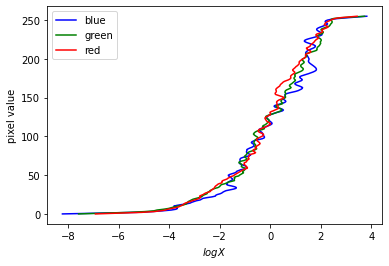

In [38]:
indices = indices_sampling(blurs, size=2000)

# Sampling images' pixel value in a (3 x N x P) form
Z = blurs.transpose(3, 1, 2, 0).reshape(3, -1, P)[:, indices]

G = []
for i in range(3):
    g, e = debevec(Z[i], img3_shutter_speed, 5, get_windows())
    G.append(g)
plot_responsive_curves(G)
img = hdr_reconstruction(images, img3_shutter_speed, G, get_windows())
#plot_radiance_map(img, center_ratio=0.2)

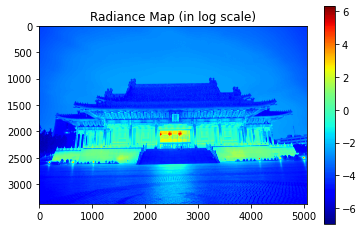

In [39]:
plot_radiance_map(img, center_ratio=0.6)

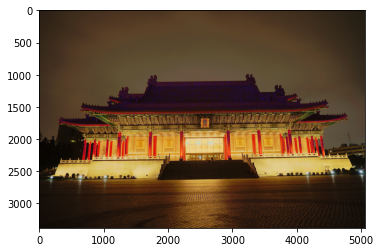

In [41]:
para = [1.3, 0, 0.3, 0]
tonemapReinhard = cv2.createTonemapReinhard(para[0], para[1], para[2], para[3])
ldr = tonemapReinhard.process(img.astype(np.float32))
cv2.imwrite('reinhard_%.1f,%.1f,%.1f,%.1f.JPG' % (para[0], para[1], para[2], para[3]), (ldr*255).astype(np.int))
plt.imshow(ldr[:, :, ::-1])